IMPORT LIBs

In [8]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numba
import cv2
from numba import jit
import pydvs.generate_spikes as gs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


d:\appdata\envs\ai\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shape', 'diff']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Image Loading Example

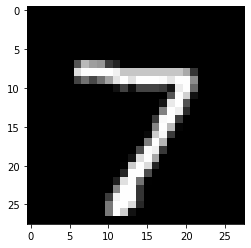

In [9]:
img_path = 'mnist/t10k/t10k-images-idx3-ubyte__idx_000__lbl_7_.png'
img = cv2.imread(img_path,0).astype('float32')
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()
vmin = 0.
vmax = img.max() 
print()

Loading Sample Images

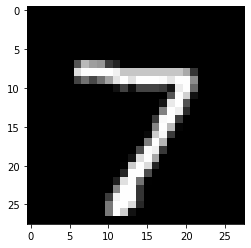

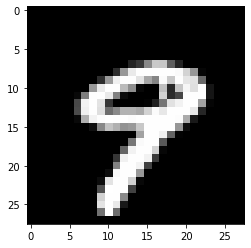

In [10]:
#read img
img_path1 = 'mnist/t10k/t10k-images-idx3-ubyte__idx_000__lbl_7_.png'
img_path2 = 'mnist/t10k/t10k-images-idx3-ubyte__idx_009__lbl_9_.png'
img1 = cv2.imread(img_path1,0).astype('int16')
img2 = cv2.imread(img_path2,0).astype('int16')
# img = cv2.resize(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY),(128, 128))
plt.figure()
plt.imshow(img1, cmap='gray')
plt.figure()
plt.imshow(img2, cmap='gray')
plt.show()

Main Variables

In [11]:
width = 28
height = 28
cam_res = 28
shape = (height, width)

data_shift = uint8( log2(cam_res) )
up_down_shift = uint8(2*data_shift)
data_mask = uint8(cam_res - 1)

polarity = 2
output_type = "TIME"
history_weight = 1.0
threshold = 12 # ~ 0.05*255
max_threshold = 180 # 12*15 ~ 0.7*255

scale_width = 0
scale_height = 0
col_from = 0
col_to = 0

curr     = np.zeros(shape,     dtype=int16) 
ref      = 128*np.ones(shape,  dtype=int16) 
spikes   = np.zeros(shape,     dtype=int16) 
diff     = np.zeros(shape,     dtype=int16) 
abs_diff = np.zeros(shape,     dtype=int16) 

# just to see things in a window
spk_img  = np.zeros((height, width, 3), np.uint8)

num_bits = 6   # how many bits are used to represent exceeded thresholds
num_active_bits = 2 # how many of bits are active
log2_table = gs.generate_log2_table(num_active_bits, num_bits)[num_active_bits - 1]
spike_lists = None
pos_spks = None
neg_spks = None
max_diff = 0
max_time_ms = int(1000./float(30))

In [255]:
@jit(parallel=True, nopython=True)
def thresholded_difference(curr_frame,ref_frame,threshold):
  """
    :param curr_frame: Latest image captured by the camera
    :param ref_frame:  Saves value when the pixel was marked as "spiking"
    :param threshold:  How big the difference between current and reference
                       frames needs to be to mark a pixel as spiking

    :return diff:     Signed difference between current and reference frames
    :return abs_diff: Absolute value of the difference
    :return spikes:   Signed pixels marked as spiking (-1 means change from higher
                      to lower brightness value, 1 means change from lower to
                      higher brightness value.)
  """
  # cdef np.ndarray[DTYPE_t, ndim=2] diff, abs_diff, spikes
  # cdef np.ndarray[DTYPE_IDX_t, ndim=1] neg_r, neg_c

  diff = curr_frame - ref_frame
  abs_diff = np.abs(diff)

  spikes = (abs_diff > threshold).astype(np.int16)

  abs_diff = (abs_diff*spikes)

  neg_r, neg_c = np.where(diff < -threshold)
  # spikes[neg_r, neg_c] = -1
  for f, b in zip(neg_r, neg_c):
    spikes[f,b] = -1


  return diff, abs_diff, spikes

pyDVS Threshold Calculating

In [268]:
diff1    = np.zeros(shape,     dtype=int16) 
diff2     = np.zeros(shape,     dtype=int16) 

%time diff1[:], abs_diff[:], spikes[:] = gs.thresholded_difference(img1, ref, threshold)
a1=abs_diff
%time diff2[:], abs_diff[:], spikes[:] = thresholded_difference(img1, ref, threshold)
a2=abs_diff
com = a1 == a2

print(com.all())


Wall time: 999 µs
Wall time: 0 ns
True


Numba function Implementation

In [39]:
@jit(nopython=True)
def argmax(ary=np.array([[]]), width=0):
    """
    The *nogil* modifier allows to be computed in parallel outside the function
    :param ary:   Array where the maximum is to be found
    :param width: Width of the array
    :returns idx: Index of the maximum value in an array
    """
    idx = 0
    val = ary[idx]
    for i in range(1, width):
        if ary[i] > val:
            idx = i
            val = ary[i]

    return idx

In [40]:
@jit(nopython=True)
def transform_coords(u, v, inh_w, ratio):
  """ Maps line to 2D area coordinates
      ------------
      | A | B |...         -----------------
      ------------   <==   | A | B | C | D |
      | C | D |...         -----------------
      ------------         | : | : | : | : |
      | : | : |.:.

    :param u:       Vertical coordinate (row index)
    :param v:       Horizontal coordinate (column index)
    :param inh_w:   Area width
    :param ratio:   Total image width to area width ratio
    :returns i, j:  Area coordinates
  """
  return inh_w*(u//ratio) + v//inh_w, inh_w*(u%ratio) + v%inh_w

In [331]:
@jit(nopython=True)
def generate_inh_coords(width,height,inh_width):
  """
    Maps all the coordinates of lines to areas in a 2D array, used to precompute
    the transformation.
    See "transform_coords(u, v, inh_w, ratio)"
    :params width:    Image width
    :params height:   Image height
    :param inh_width: Area width
    :returns coords:  An array of transformed coordinates [[row0, col0]...[rowN, colN]]
  """
  new_w = inh_width*inh_width
  new_h = (height*width)//new_w
  ratio = width//inh_width

  ar = np.array([transform_coords(u, v, inh_width, ratio) \
                                        for u in range(new_h) \
                                        for v in range(new_w)])

  return ar.astype(np.int16)

Croodds Generation base on desired implementation

In [333]:
%time inh_coords = generate_inh_coords(28, 28, 2)
#%time inh_coords = gs.generate_inh_coords(28, 28, 2)
#inh_coords

Wall time: 0 ns


In [392]:
from numba import prange
@jit(nopython=True)
def local_inhibition(spikes,abs_diff,inh_coords,width,height,inh_width):
  """ Searches for the largest change in an area and removes spiking mark
      from the other pixels.
      :param spikes:      Marks of pixels
      :param abs_diff:    Absolute value of the brightness change
      :param inh_coords:  Precomputed coordinate transformation
      :param width:       Image width
      :param height:      Image height
      :param inh_width:   Inhibition area width (square area)
      :returns spikes:    Locally inhibited spikes
  """
  ROWS =0
  COLS = 1
  # spikes = spikes[0,:]
#   cdef Py_ssize_t u, v, new_w, new_h, ratio

#~   cdef np.ndarray[DTYPE_t, ndim=2] reshaped
#   cdef DTYPE_t[:,:] reshaped
#   cdef np.ndarray[DTYPE_t, ndim=1] max_vals
#   cdef np.ndarray[Py_ssize_t, ndim=2] max_indices
#   cdef np.ndarray[Py_ssize_t, ndim=1] max_local_indices


  new_w = inh_width*inh_width
  new_h = (height*width)//new_w
  ratio = width//inh_width

  print(new_h)
  print(new_w)

  #(w*h/inh_w^2, inh_w^2) so we can efficiently find local max
  ros = inh_coords[:, ROWS]
  wos = inh_coords[:, COLS]

  combined = np.vstack((ros, wos))
  s=abs_diff.take(combined)
  print(s.shape)
  reshaped = s.reshape((new_h, new_w))
  # max_local_indices = np.zeros(new_h)
  # #allow parallel compute of max indices
  # for v in prange(new_h):
  #   max_local_indices[v] = argmax(reshaped[v],new_w)


  # max_indices = np.array([[]])
  # for u in range(new_h):
  #   max_indices =np.append(max_indices,transform_coords(u, max_local_indices[u], inh_width, ratio) )
  #   print(type(transform_coords(u, max_local_indices[u], inh_width, ratio)))

  
  # max_indices = np.array([transform_coords(u, max_local_indices[u], inh_width, ratio) for u in range(new_h)])
  # combined = np.vstack((max_indices[:, ROWS], max_indices[:, COLS]))
  # print(combined)
  # max_vals = spikes.take(combined)
  # # max_vals = spikes[max_indices[:, ROWS], max_indices[:, COLS]]
  # spikes[:] = 0
  # spikes[max_indices[:, ROWS], max_indices[:, COLS]] = max_vals


  return spikes

Local inhibition Performance Testing

In [393]:
%time spikes[:] = local_inhibition(spikes, abs_diff, inh_coords, width, height, 2)
# %time spikes[:] = gs.local_inhibition(spikes, abs_diff, inh_coords, width, height, 2)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mInvalid use of BoundFunction(array.reshape for array(int16, 2d, C)) with parameters (Tuple(float64, int64))
[0m
[0m[1mDuring: resolving callee type: BoundFunction(array.reshape for array(int16, 2d, C))[0m
[0m[1mDuring: typing of call at <ipython-input-392-5d569244275c> (40)
[0m
[1m
File "<ipython-input-392-5d569244275c>", line 40:[0m
[1m#   cdef np.ndarray[Py_ssize_t, ndim=1] max_local_indices
    <source elided>
  print(s.shape)
[1m  reshaped = s.reshape((new_h, new_w))
[0m  [1m^[0m[0m


update the reference

In [418]:
@jit(nopython=True)
def update_reference_time_binary_thresh(abs_diff,spikes,ref_frame,threshold,max_time_ms,num_spikes,history_weight,log2_table):

  """
    Time based spike transmission.
    :param abs_diff:        Absolute value of the difference of current frame and
                            reference frame (computed in *thresholded_difference*)
    :param spikes:          Pixels marked as spiking
    :param ref_frame:       Previous reference frame
    :param threshold:       How much brightness has to change to mark a pixel as spiking
    :param max_time_ms:     Number of milliseconds between each frame (saturation limit)
    :param num_spikes:      Number of active bits to use in the encoding
    :param history_weight:  How much does the previous reference frame weighs in the
                            update equation
    :param log2_table:      Precomputed versions of the raw difference using only num_spikes
                            active bits
    :returns ref_frame:     Updated reference frame

    Binary encoding of the number of thresholds rebased by the brightness difference,
    using only num_spikes active bits

    TH <- Threshold value
    T  <- Inter frame time (1/frames per second)

   t=0 _______________|_____|________ t=T
       |     |     |     |     |     |
   bit    5     4     3     2     1
   val                8     2
   original = 125, threshold = 12 => ~10 thresholds
   encoded with only 2 active bits = 10*12 = 120

  """
  logTab = abs_diff//threshold
  mult = log2_table.take(logTab)
  # mult = (log2_table[abs_diff//threshold])

  ref_frame = np.clip( (history_weight*ref_frame) + spikes*mult*threshold, 0, 255)

  return ref_frame

In [424]:
r1 = np.zeros_like(ref)
r2 = np.zeros_like(ref)
%time r1[:] = gs.update_reference_time_binary_thresh(abs_diff, spikes, ref,threshold, max_time_ms,num_active_bits,history_weight,log2_table)
%time r2[:] = update_reference_time_binary_thresh(abs_diff, spikes, ref,threshold, max_time_ms,num_active_bits,history_weight,log2_table)

r = r1 == r2
r.all()

Wall time: 0 ns
Wall time: 0 ns


True

In [439]:
@jit(nopython=True)
def render_frame(spikes,curr_frame,width,height,polarity):
  """
    Overlaps the generated spikes onto the latest image from the video
    source. Red means a negative change in brightness, Green a positive one.

    :param spikes:     Pixels marked as spiking
    :param curr_frame: Latest image from the video source
    :param width:      Image width
    :param height:     Image height
    :param polarity:   Wether to report positive, negative or both changes
                       in brightness
    :returns spikes_frame: Combined spikes/image information in a color image
  """
  spikes_frame = np.zeros((height, width, 3), np.uint8)
  # cdef np.ndarray[Py_ssize_t, ndim=1] rows, cols
  spikes_frame[:, :, 0] = curr_frame
  spikes_frame[:, :, 1] = curr_frame
  spikes_frame[:, :, 2] = curr_frame

  rows, cols = np.where(spikes > 0)
  for r,c in zip(rows, cols):
    spikes_frame[r, c, :] = [0, 255, 0]

  rows, cols = np.where(spikes < 0)
  for r,c in zip(rows, cols):
    spikes_frame[r, c, :] = [0, 0, 255]
  # spikes_frame[rows, cols, :] = [0, 0, 255]

  return spikes_frame

Display Preparation

Wall time: 636 ms


<Figure size 432x288 with 0 Axes>

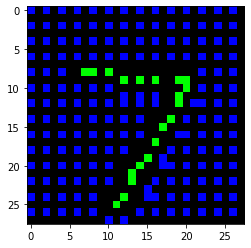

<Figure size 432x288 with 0 Axes>

In [440]:
# %time spk_img[:] = gs.render_frame(spikes, curr, cam_res, cam_res, polarity) 
%time spk_img[:] = render_frame(spikes, curr, cam_res, cam_res, polarity) 
plt.figure()
plt.imshow(spk_img.astype(np.uint8))
plt.figure()

Complete DVS Process Testing Function

In [460]:
a = np.array([[1,2],[1,2]])
print(a)
np.tile(a,(3,1,1))

[[1 2]
 [1 2]]


array([[[1, 2],
        [1, 2]],

       [[1, 2],
        [1, 2]],

       [[1, 2],
        [1, 2]]])

update the reference

In [80]:
def doSpike(current_frame):
    %time diff[:], abs_diff[:], spikes[:] = gs.thresholded_difference(current_frame, ref, threshold)
    %time spikes[:] = local_inhibition(spikes, abs_diff, inh_coords, width, height, 2)
    %time ref[:] = gs.update_reference_time_binary_thresh(abs_diff, spikes, ref,threshold, max_time_ms,num_active_bits,history_weight,log2_table)
    %time spk_img[:] = gs.render_frame(spikes, current_frame, cam_res, cam_res, polarity) 
    plt.figure()
    plt.imshow(spk_img.astype(np.uint8))
    plt.figure()

Wall time: 0 ns


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(int16, 2d, C), UniTuple(array(int64, 1d, A) x 2))
 
There are 22 candidate implementations:
[1m    - Of which 20 did not match due to:
    Overload of function 'getitem': File: <numerous>: Line N/A.
      With argument(s): '(array(int16, 2d, C), UniTuple(array(int64, 1d, A) x 2))':[0m
[1m     No match.[0m
[1m    - Of which 2 did not match due to:
    Overload in function 'GetItemBuffer.generic': File: numba\core\typing\arraydecl.py: Line 162.
      With argument(s): '(array(int16, 2d, C), UniTuple(array(int64, 1d, A) x 2))':[0m
[1m     Rejected as the implementation raised a specific error:
       NotImplementedError: only one advanced index supported[0m
  raised from d:\appdata\envs\ai\lib\site-packages\numba\core\typing\arraydecl.py:65
[0m
[0m[1mDuring: typing of intrinsic-call at <ipython-input-71-bb2ad1734856> (30)[0m
[1m
File "<ipython-input-71-bb2ad1734856>", line 30:[0m
[1m#   cdef np.ndarray[Py_ssize_t, ndim=1] max_local_indices
    <source elided>
  #(w*h/inh_w^2, inh_w^2) so we can efficiently find local max
[1m  reshaped = abs_diff[inh_coords[:, ROWS], inh_coords[:, COLS]].reshape((new_h, new_w))
[0m  [1m^[0m[0m


Wall time: 0 ns
Wall time: 0 ns
Wall time: 22 ms
Wall time: 0 ns


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(int16, 2d, C), UniTuple(array(int64, 1d, A) x 2))
 
There are 22 candidate implementations:
[1m    - Of which 20 did not match due to:
    Overload of function 'getitem': File: <numerous>: Line N/A.
      With argument(s): '(array(int16, 2d, C), UniTuple(array(int64, 1d, A) x 2))':[0m
[1m     No match.[0m
[1m    - Of which 2 did not match due to:
    Overload in function 'GetItemBuffer.generic': File: numba\core\typing\arraydecl.py: Line 162.
      With argument(s): '(array(int16, 2d, C), UniTuple(array(int64, 1d, A) x 2))':[0m
[1m     Rejected as the implementation raised a specific error:
       NotImplementedError: only one advanced index supported[0m
  raised from d:\appdata\envs\ai\lib\site-packages\numba\core\typing\arraydecl.py:65
[0m
[0m[1mDuring: typing of intrinsic-call at <ipython-input-71-bb2ad1734856> (30)[0m
[1m
File "<ipython-input-71-bb2ad1734856>", line 30:[0m
[1m#   cdef np.ndarray[Py_ssize_t, ndim=1] max_local_indices
    <source elided>
  #(w*h/inh_w^2, inh_w^2) so we can efficiently find local max
[1m  reshaped = abs_diff[inh_coords[:, ROWS], inh_coords[:, COLS]].reshape((new_h, new_w))
[0m  [1m^[0m[0m


Wall time: 0 ns
Wall time: 0 ns
Wall time: 21.1 ms


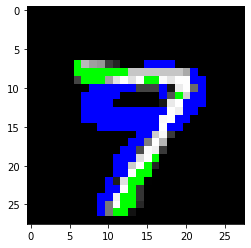

<Figure size 432x288 with 0 Axes>

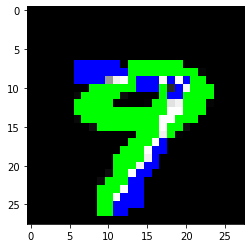

<Figure size 432x288 with 0 Axes>

In [81]:
%time doSpike(img1)
%time doSpike(img2)

Inline Cython Testing

In [82]:
%load_ext cython

In [83]:
%%cython -a -f -c=-DCYTHON_TRACE=1
# cython: linetrace=True
# cython: binding=True

import numpy as np

cdef int max(int a, int b):
    return a if a > b else b

def chebyshev(int x1, int y1, int x2, int y2):
    return max(abs(x1 - x2), abs(y1 - y2))

def c_benchmark():
    a = np.random.rand(1000, 2)
    b = np.random.rand(1000, 2)

    for x1, y1 in a:
        for x2, y2 in b:
            chebyshev(x1, x2, y1, y2)



In [84]:

%timeit c_benchmark()

801 ms ± 4.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [239]:
@jit(parallel=True, nopython=True)
def thresholded_difference(
        frame: np.ndarray, reference: np.ndarray, thresholds: np.ndarray,
        spikes: np.ndarray):
    active = np.zeros_like(frame, dtype=uint8)

    spikes[:] = frame - reference
    active[:] = (np.abs(spikes) >= thresholds)
    spikes *= active
    # todo: since outputs are spikes, how do I discretize increments?
    # is this the right way?
    spikes[:] = (spikes // thresholds) * thresholds

    return active